## Final Project

### Prepare Environment

Install libraries and load modules

In [1]:
!pip install python-chess==1.2.0

In [2]:
# use ray which is 10x faster than the multiprocessing libary in python
!pip install -U ray

In [3]:
!pip install numpy --upgrade

In [4]:
!wget https://stockfishchess.org/files/stockfish_14.1_linux_x64.zip
!unzip -o stockfish_14.1_linux_x64.zip
!chmod +x stockfish_14.1_linux_x64/stockfish_14.1_linux_x64

--2021-11-28 21:10:51--  https://stockfishchess.org/files/stockfish_14.1_linux_x64.zip
Resolving stockfishchess.org (stockfishchess.org)... 104.25.159.9, 104.25.158.9, 172.67.80.249, ...
Connecting to stockfishchess.org (stockfishchess.org)|104.25.159.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28788691 (27M) [application/zip]
Saving to: ‘stockfish_14.1_linux_x64.zip.11’

stockfish_14.1_linu 100%[===================>]  27.45M   147MB/s    in 0.2s    

2021-11-28 21:10:51 (147 MB/s) - ‘stockfish_14.1_linux_x64.zip.11’ saved [28788691/28788691]

Archive:  stockfish_14.1_linux_x64.zip
  inflating: stockfish_14.1_linux_x64/AUTHORS  
  inflating: stockfish_14.1_linux_x64/Copying.txt  
  inflating: stockfish_14.1_linux_x64/info.txt  
  inflating: stockfish_14.1_linux_x64/stockfish_14.1_linux_x64  
  inflating: stockfish_14.1_linux_x64/stockfish_14.1_src/.github/workflows/stockfish.yml  
  inflating: stockfish_14.1_linux_x64/stockfish_14.1_src/.gitignore  
  in

In [5]:
import chess
import chess.pgn as pgn
import chess.engine

import psutil
import ray
from ray.util.multiprocessing import Pool

import numpy as np
import math
import random
from datetime import date
import time
from IPython.display import display
import pandas as pd

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend

#import keras as K
#from keras import optimizers
#from keras import layers
#from keras import models
#from keras import backend

In [6]:
# increase limits for multiprocessing
import sys
sys.setrecursionlimit(10000)

if ray.is_initialized():
  ray.shutdown()
ray.init()
pool = Pool()

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
for gpu in tf.config.list_physical_devices('GPU'):
    print('\t{}'.format(gpu))

Num GPUs Available:  1
	PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2021-11-28 21:10:59.823824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 21:10:59.924649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 21:10:59.925538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [7]:
print('TensorFlow Version: {}'.format(tf.__version__))
print('Keras Version: {}'.format(tf.keras.__version__))
print('Numpy Version: {}'.format(np.version.version))

TensorFlow Version: 2.7.0
Keras Version: 2.7.0
Numpy Version: 1.21.4


In [8]:
import os
os.getcwd()
save_path = os.getcwd() + '/Models'
print('Save path set to: {}'.format(save_path))

Save path set to: /home/jupyter/Models


### Class: Node

The class node is used to build trees for use in a monte carlo tree search

In [9]:
class node():
  def __init__(self):
    self.state = chess.Board()
    self.action = ''
    self.children = set()
    self.parent = None
    self.N = 0
    self.n = 0
    self.v = 0

choices = []

def reset_choices():
  global choices
  choices = []

### Class: ActionSpace

The ActionSpace class is used to interprete current state of a game

In [10]:
class ActionSpace():
  def __init__(self, board):
    self.board = board

  def sample(self) -> str:
    """
    Returns a random legal move as a string in algebraic notation
    :return: move as a string
    """
    return random.choice(self.available_actions())

    def available_actions(self) -> list[str]:
      """
      Returns a list of legal moves as a list of strings where the moves
      are in algebraic notation
      :return: list of moves
      """
      legal_moves = list(self.board.legal_moves)
      legal_moves_str = [str(move) for move in legal_moves]
      return legal_moves_str

### Class: ChessEnv

Configures a chess environment for use in a game

In [11]:
class ChessEnv():
  """
  Chess Environment. Player is always white. Opponent is black
  """

  def __init__(self, opponent):
    self.opponent = opponent
    self.board = chess.Board()
    self.game = chess.pgn.Game()
    self.game.headers['White'] = 'Player'
    if self.opponent != None:
      self.game.headers['Black'] = self.opponent.name
    self.game.headers['Date'] = str(date.today())
    self.node = self.game
    if self.opponent != None:
      self.action_space = ActionSpace(self.board)
    else:
      self.init_action_space()
      self.layer_board = np.zeros(shape=(8,8,8))
    self.init_layer_board()

  def init_action_space(self):
    """
    Initialize the actions space
    """
    self.action_space = np.zeros(shape=(64,64))
  
  def init_layer_board(self):
    """
    Initialize the numerical representation of the envrionment
    """
    mapper = {'p': 0, 'r': 1, 'n': 2, 'b': 3, 'q': 4, 'k': 5, 'P': 0, 'R': 1, 'N': 2, 'B': 3, 'Q': 4, 'K': 5}
    self.layer_board = np.zeros(shape=(8,8,8))
    for i in range(64):
      row = i // 8
      col = i % 8
      piece = self.board.piece_at(i)
      if piece == None:
        continue
      elif piece.symbol().isupper():
        sign = 1
      else:
        sign = -1
      layer = mapper[piece.symbol()]
      self.layer_board[layer, row, col] = sign
    if self.board.turn:
      self.layer_board[6, :, :] = 1 / self.board.fullmove_number
    if self.board.can_claim_draw():
      self.layer_board[7, :, :] = 1

  def _observation(self) -> str:
    """
    Returns the state of the game in Forsyth-Edwards Notation (FEN)
    :return: observation
    """
    return self.board.fen()

  def _is_done(self) -> bool:
    """
    :return: Return True if the game is over, else False
    """
    return self.board.is_game_over()

  def _reward(self) -> int:
    """
    Returns a reward from white's perspective
    Game not over = 0
    Win = +1
    Loss = -1
    Draw = 0
    :return: reward
    """
    if not self._is_done():
      reward = 0
    else:
      result = self.board.result()
      if result == '1-0':
        reward = 1
      elif result == '0-1':
        reward = -1
      elif result == '1/2-1/2':
        reward = 0
      else:
        raise Exception('Unknown end game state')
    return reward

  def reset(self) -> str:
    """
    Resets the game and returns an observation
    :return: observaction
    """
    self.board = chess.Board()
    self.game = chess.pgn.Game()
    self.game.headers['White'] = 'Player'
    if self.opponent != None:
      self.game.headers['Black'] = self.opponent.name
      self.init_action_space()
    self.game.headers['Date'] = str(date.today())
    self.node = self.game
    self.init_layer_board()
    return self._observation

  def render_image(self, **kwargs):
    return chess.svg.board(self.board, **kwargs)

  def render_txt(self):
    print('\n')
    print(self.board)
    print('\n')

  def render_image_jupyter(self):
    display(self.board)

  def step(self, action: str):
    """
    :param action: action in san
    """
    self.board.push_san(action)

  def step_numerical(self, action):
    """
    Run a step
    Args:
      action: tuple of 2 integers
        Move from, Move to
    Returns:
      episode end: Boolean
        Whether the episode has ended
      reward: int
        Difference in material value after the move
    """
    piece_balance_before = self.get_material_value()
    self.board.push(action)
    self.init_layer_board()
    piece_balance_after = self.get_material_value()
    if self.board.result() == '*':
      opponent_move = self.get_random_action()
      self.board.push(opponent_move)
      self.init_layer_board()
      capture_reward = piece_balance_after - piece_balance_before
      if self.board.result() == '*':
        reward = 0 + capture_reward
        episode_end = False
      else:
        reward = 0 + capture_reward
        episode_end = True
    else:
      capture_reward = piece_balance_after - piece_balance_before
      reward = 0 + capture_reward
      episode_end = True
    if self.board.is_game_over():
      reward = 0
      episode_end = True
    return episode_end, reward

  def get_random_action(self):
    """
    Sample a random action
    Returns: move
      A legal chess move
    """
    legal_moves = [x for x in self.board.generate_legal_moves()]
    legal_moves = np.random.choice(legal_moves)
    return legal_moves

  def get_material_value(self):
    """
    Sums up the material balance using Reinfield values
    Returns: The material balance on the board
    """
    pawns = 1 * np.sum(self.layer_board[0, :, :])
    rooks = 5 * np.sum(self.layer_board[1, :, :])
    minor = 3 * np.sum(self.layer_board[2:4, :, :])
    queen = 9 * np.sum(self.layer_board[4, :, :])
    return pawns + rooks + minor + queen

  def project_legal_moves(self):
    """
    Create a mask of legal actions
    Returns: np.ndarray with shape (64, 64)
    """
    self.action_space = np.zeros(shape=(64, 64))
    moves = [[x.from_square, x.to_square] for x in self.board.generate_legal_moves()]
    for move in moves:
      self.action_space[move[0], move[1]] = 1
    return self.action_space

### Class: MCTSAgent()

Create an agent that uses monte carlo tree search to determine a move

In [12]:
class MCTSAgent():
    def __init__(self, name: str, is_white: bool, multithreading=True):
        self.name = name
        self.is_white = is_white
        self.multithreading = multithreading
        print('Created Agent ''{}'' as {}; multithreading: {}'.\
              format(name, 'White' if is_white else 'Black', multithreading))

    def expand(self, current_node):
        """
        Expanding is used to increase the options further in the game by expanding
        the selected node and creating many children nodes
        :param current_node: node to expand, is_white: white or black player
        :return: the current node with the expanded children
        """
        if len(current_node.children) == 0:
            return current_node
        expanded_child = self.mcts_identify_best_ucb(current_node, self.is_white, True)
        return self.expand(expanded_child)

    def rollout(self, current_node):
        """
        Run a simulated rollout from M until a terminal state is found. The terminal state 
        contains a result (value) that will be returned to upwards in the is 
        backpropagation phase
        params: current_node: node to simulate
        return: the terminal state
        """
        if current_node.state.is_game_over():
            board = current_node.state
            if board.result() == '1-0':
                return 1, current_node
            elif board.result() == '0-1':
                return -1, current_node
            else:
                return 0.5, current_node
    
        all_moves = [current_node.state.san(i) for i in list(current_node.state.legal_moves)]

        for move in all_moves:
            tmp_state = chess.Board(current_node.state.fen())
            tmp_state.push_san(move)
            child = node()
            child.state = tmp_state
            child.parent = current_node
            current_node.children.add(child)
    
        random_state = random.choice(list(current_node.children))

        return self.rollout(random_state)

    def rollback(self, current_node, reward):
        """
        After the simulation phase, a result is returned. All nodes from M up to R 
        will be updated by adding the result to their value and increase the count of visits at each node
        params: current_node: the node with all children, reward: the reward to roll backpropagate
        returns: current_node with updated rewards
        """
        current_node.n += 1
        current_node.v += reward
        while(current_node.parent != None):
            current_node.N += 1
            current_node = current_node.parent
        return current_node

    def mcts_parallel_operation(self, item):
        """
        Performs a multiprocess exeuction to obtain the upper control bound of a given node
        params: i: process, child: node, idx: object reference id for node
        returns: tupple of idx, child, ucb
        """
        # Calculate the upper confidence bounds (UCB)
        child = item[0]
        idx = item[1]
        ucb = child.v + 2 * (math.sqrt(math.log(child.N + math.e + (10**-6)) / (child.n + (10**-10))))
        result = (idx, ucb)
        return result

    def mcts_identify_best_ucb(self, current_node, is_white, flip = False):
        """
        Determines the upper confidence bounds of each child in a given node
        params: current_node: the node, is_white: white or black player
        returns: sel_child: the child with the best upper confidence bounds
        """
        # create children to calculate UCB
        ref_child = {}
        pool_members = []
        idx = 0

        # build pool members to parallelize
        for child in current_node.children:
            ref_child[idx] = child
            pool_members.append((child, idx))
            idx+=1

        if self.multithreading:
            # run parallel collection of UCB across al node children
            global pool
            mcts_list = pool.map(self.mcts_parallel_operation, pool_members, chunksize=1000000)
        else:
            mcts_list = map(self.mcts_parallel_operation, pool_members)
        mcts_list = list(mcts_list)

        if flip:
            _param = 0 if is_white else 1
        else:
            _param = is_white

        if _param:
            max_idx = np.argmax(np.array(mcts_list)[:,1])
            max_idx = np.array(mcts_list)[max_idx,0]
            sel_child = ref_child[max_idx]
        else:
            min_idx = np.argmin(np.array(mcts_list)[:,1])
            min_idx = np.array(mcts_list)[min_idx,0]
            sel_child = ref_child[min_idx]

        mcts_list.clear()
        return sel_child

    # Monte Carlo Tree Search
    def observe(self, current_node, is_over=False, iterations=10, env=None):
        """
        Performs a monte carlo tree search on a given node
        params: the node to perform a MCTS
        returns: selected_move: the best move
        """
        if is_over:
            return -1
    
        root = node()
        root.state = current_node
        current_node = root

        all_moves = [current_node.state.san(i) for i in list(current_node.state.legal_moves)]
        map_state_move = dict()

        for move in all_moves:
            tmp_state = chess.Board(current_node.state.fen())
            tmp_state.push_san(move)
            child = node()
            child.state = tmp_state
            child.parent = current_node
            current_node.children.add(child)
            map_state_move[child] = move

        while(iterations > 0):
            sel_child = self.mcts_identify_best_ucb(current_node, self.is_white)
            ex_child = self.expand(sel_child)
            reward, state = self.rollout(ex_child)
            current_node = self.rollback(state, reward)

            iterations -= 1

        selected_move = ''
        sel_child = self.mcts_identify_best_ucb(current_node, self.is_white)
        selected_move = map_state_move[sel_child]
    
        return selected_move

### Class: StockfishAgent()

Create an agent that uses the stockfish engine

In [13]:
class StockfishAgent():
  def __init__(self, name: str, is_white: bool, skill_lvl = 1):
    self.name = name
    self.is_white = is_white
    self.engine = chess.engine.SimpleEngine.popen_uci('stockfish_14.1_linux_x64/stockfish_14.1_linux_x64')
    # set skill level
    self.engine.configure({"Skill Level": skill_lvl})

    print('Created Agent ''{}'' as {}; Using Stockfish engine lvl: {}'.\
          format(name, 'White' if is_white else 'Black', skill_lvl))
    
  def observe(self, state, env=None):
    board = state
    result = self.engine.play(board, chess.engine.Limit(time=0.1))
    selected_move = str(result.move)
    return selected_move

###Class: ActorCritic()

Create an agent that uses actor critic methods that is guided by the functions
- actor - a policy function that picks what moves to play
- criric - tracks whether the agent is ahead or behind in the game

In [14]:
#from tensorflow.keras import optimizers
#from tensorflow.keras import layers
#from tensorflow.keras import models
#from tensorflow.keras import backend

In [15]:
class ActorCriticAgent():
  def __init__(self, gamma=0.5, network='cnn', lr=0.01, verbose=0, cnn_layers=3, dense_layers=1, name=None):
    """
    Agent that plays the white pieces using the actor critic learning method
    Args:
      gamma: float
        Temporal discount factor
      network: str
        'linear' or 'conv'
      lr: float
        Learning reate, default is 0.01
      verbose: int
        The level of verbosity used in the model
    """
    self.gamma = gamma
    self.lr = lr
    self.verbose = verbose
    self.name = name
    self.weight_memory = []
    self.long_term_mean = []
    if network == 'cnn':
      self.model = self.build_network_cnn(cnn_layers=cnn_layers, dense_layers=dense_layers)
    elif network == 'cnn_pg':
      self.model = self.built_network_cnn_policy_gradients(cnn_layers=cnn_layers, dense_layers=dense_layers)
    else:
      Exception('Error: Incorrect network defined when setting up Agent')
    print('Created Agent ''{}'''.format(self.name))

  def build_network_cnn(self, cnn_layers=1, dense_layers=1):
    """
    Initializes a convolutional neural network (CNN)
    """
    optimzer = optimizers.SGD(learning_rate=self.lr, momentum=0.0, decay=0.0, nesterov=False)
    inputs = layers.Input(shape=(8,8,8), name='board_layer')
    Conv = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    if cnn_layers > 1:
      for i in range(cnn_layers-1):
        Conv = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(Conv)
    mlp = layers.Flatten()(Conv)
    if dense_layers > 1:
      for i in range(dense_layers-1):
        mlp = layers.Dense(64, activation='relu')(mlp)
    predictions = layers.Dense(4096, activation='relu')(mlp)
    model = models.Model(inputs=[inputs], outputs=[predictions])
    model.compile(optimizer=optimzer, loss='mse', metrics=['mae'])
    return model
  
  def built_network_cnn_policy_gradients(self, cnn_layers=1, dense_layers=1):
    """
    Convolutional neural network (CNN) for policy gradients
    """
    inputs = layers.Input(shape=(8,8,8), name='board_layer')
    rewards = layers.Input(shape=(1,), name='Rewards')
    legal_moves = layers.Input(shape=(4096,), name='legal_move_mast')
    optimzer = optimizers.SGD(learning_rate=self.lr, momentum=0.0, decay=0.0, nesterov=False)
    
    Conv_1 = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    if cnn_layers > 1:
      for i in range(cnn_layers-1):
        Conv_1 = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(Conv_1)
    mlp_1 = layers.Flatten()(Conv_1)
    mlp_1 = layers.Dense(64, activation='relu')(mlp_1)
    if dense_layers > 1:
      for i in range(dense_layers-1):
        mlp_1 = layers.Dense(64, activation='relu')(mlp_1)
    predictions = layers.Dense(4096, activation='softmax')(mlp_1)###
    legal_predictions = layers.Multiply()([legal_moves, predictions])
    model = models.Model(inputs=[inputs, rewards, legal_moves], outputs=[legal_predictions])
    model.compile(optimizer=optimzer, loss=self.policy_gradient_loss(rewards))
    return model

  def policy_gradient_loss(self, Returns):
    def modified_crossentropy(action, action_probs):
      cost = backend.categorical_crossentropy(action, action_probs, from_logits=False, axis=1) * Returns
      return backend.mean(cost)
    return modified_crossentropy
  
  def update_model(self):
    """
    Updates to model for use with bootstrapping
    """
    optimizer = optimizers.SGD(learning_rate=self.lr, momentum=0.0, decay=0.0, nesterov=False)
    #optimizer = optimizers.gradient_descent_v2.SGD(learning_rate=self.lr, momentum=0.0, decay=0.0, nesterov=False)
    #optimizer = optimizers.Adam(learning_rate=self.lr)
    self.updated_model = models.clone_model(self.model)
    self.updated_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    self.updated_model.set_weights(self.model.get_weights())

  def network_update(self, minibatch):
    """
    Updates the Q-network using samples from the minibatch
    Args:
      minibatch: list
        The minibatch contains the states, moves, rewards and new states
    Returns:
      td_errors: np.array
        array of temporal difference errors
    """

    # Prepare separate lists
    states, moves, rewards, new_states = [], [], [], []
    td_errors = []
    episode_ends = []
    for sample in minibatch:
      states.append(sample[0])
      moves.append(sample[1])
      rewards.append(sample[2])
      new_states.append(sample[3])

      # Episode end detection
      if np.array_equal(sample[3], sample[3] * 0):
        episode_ends.append(0)
      else:
        episode_ends.append(1)
    
    # The Q target
    q_target = np.array(rewards) + np.array(episode_ends) * self.gamma * np.max(self.updated_model.predict(np.stack(new_states, axis=0)), axis=1)
    
    # The Q value for remaining actions
    q_state = self.model.predict(np.stack(states, axis=0)) # batch x 64 x 64

    # Combine the Q target with the other Q values
    q_state = np.reshape(q_state, (len(minibatch), 64, 64))
    for idx, move in enumerate(moves):
      td_errors.append(q_state[idx, move[0], move[1]] - q_target[idx])
      q_state[idx, move[0], move[1]] = q_target[idx]
    q_state = np.reshape(q_state, (len(minibatch), 4096))

    # Perform a step of minibatch Gradient Descent
    self.model.fit(x=np.stack(states, axis=0), y=q_state, epochs=1, verbose=0)

    return td_errors

  def get_action_values(self, state):
    """
    Get action values of a state
    Args:
      state: np.ndarray with shape (8,8,8)
        layer_board representation
    Returns:
      action avalues
    """
    return self.updated_model.predict(state) + np.random.randn() * 1e-9

  def policy_gradient_update(self, states, actions, rewards, action_spaces):
    """
    Update parameters with Monte Carlo Policy Gradient algorithm
    Args:
      states: (list of tuples) state sequence in episode
      actions: action sequence in episode
      rewards: rewards sequence in episode
    """
    n_steps = len(states)
    Returns = []
    targets = np.zeros((n_steps, 64, 64))
    for t in range(n_steps):
      action = actions[t]
      targets[t, action[0], action[1]] = 1
      R = rewards[t, action[0] * 64 + action[1]]
      Returns.append(R)
    
    train_returns = np.stack(Returns, axis=0) #np.stack(Returns, axis=0)
    targets = targets.reshape((n_steps, 4096))
    self.weight_memory.append(self.model.get_weights())
    self.model.fit(x=[np.stack(states, axis=0), train_returns, np.concatenate(action_spaces, axis=0)], y=[np.stack(targets, axis=0)], verbose=self.verbose)
    #self.model.fit(x=[tf.stack(states, axis=0), train_returns, np.concatenate(action_spaces, axis=0)], 
    #               y=[tf.stack(targets, axis=0)], verbose=self.verbose)
    
  def save_model(self, name):
    self.model.save_weights(name)
  
  def load_model(self, name):
    self.model.load_weights(name)
    
  def observe(self, state, env): #maxiter=25, 160
    """
    Observe a move and return the action
    Args:
      state:
        state of the board
    """
    state = env.layer_board
    action_space = env.project_legal_moves() # determine which moves are legal
    action_probs = self.model.predict([np.expand_dims(state, axis=0), np.zeros((1,1)), action_space.reshape(1, 4096)])
    action_probs = action_probs / action_probs.sum()
    move_probs = np.squeeze(action_probs)
    move = np.random.choice(range(4096), p=move_probs)
    move_from = move // 64
    move_to = move % 64
    moves = [x for x in env.board.generate_legal_moves() if x.from_square == move_from and x.to_square == move_to]
    assert len(moves) > 0 # should not be possible
    if len(moves) > 1:
        move = np.random.choice(moves) # If there are multiple max-moves, pick a random one
    elif len(moves) == 1:
        move = moves[0]
    return move

In [16]:
class ActorCritic():
  def __init__(self, actor, critic, env):
    """
    Actor Critic object to learn chess
    Args:
      actor: policy gradient agent
      critic: Q-learning agent
      env: the chess environment
      memsize: maximum amount of games to retain in-memory
    """
    self.actor = actor
    self.critic = critic
    self.env = env
    self.reward_trace = []
    self.action_value_memory = []
    self.memory = []
    self.sampling_probs = []

  def learn(self, iters=100, c=10):
    """
    Runs the Q learning algorithm. The final iteration will play greedy
    Args:
      iters: int
        amount of games to train
      c: int
        update the network every c games
    Returns: pgn (str)
      pgn string describing the final game
    """
    for i in range(iters):
      if i % c == 0:
        self.critic.update_model()
      self.env.reset()
      end_state = self.play_game(i)
      # save checkpoints
      z = i+1
      if z % 10 == 0 and z != 1:
        actor_save_path = save_path+'/actor_{}.h5'.format(z)
        actor.save_model(name=actor_save_path)
        print('...saved (actor): {}'.format(actor_save_path))
        critic_save_path = save_path+'/critic_{}.h5'.format(z)
        critic.save_model(name=critic_save_path)
        print('...saved (critic): {}'.format(critic_save_path))

    _pgn = pgn.Game.from_board(self.env.board)
    reward_smooth = pd.DataFrame(self.reward_trace)
    reward_smooth.rolling(window=10, min_periods=0).mean().plot()

    # save final models
    actor.save_model(name=save_path+'/actor_final.h5')
    critic.save_model(name=save_path+'/critic_final.h5')
    return _pgn    
  
  def play_game(self, i, greedy=False, maxiter=60): #maxiter=25, 160
    """
    Play a game of chess
    Args:
      i: int
        game count, determines the epsilon (exploration rate)
      greedy: boolean
        if greedy, no exploration is done
      maxiter: int
        maximum amount of steps per game
    """

    episode_end = False
    turn_count = 0
    
    # play game
    state = self.env.layer_board
    start = time.time()
    update_actor = True
    while not episode_end:
      state = self.env.layer_board
      action_space = self.env.project_legal_moves() # determine which moves are legal
      action_probs = self.actor.model.predict([np.expand_dims(state, axis=0), np.zeros((1,1)), action_space.reshape(1, 4096)])
      action_probs_tmp = action_probs
      self.action_value_memory.append(action_probs)
      action_probs = action_probs / action_probs.sum()
      move_probs = np.squeeze(action_probs)
      if np.isnan(move_probs).any():
        episode_end = True    
        update_actor = False
      else:
        move = np.random.choice(range(4096), p=move_probs)
        move_from = move // 64
        move_to = move % 64
        moves = [x for x in self.env.board.generate_legal_moves() if x.from_square == move_from and x.to_square == move_to]
        assert len(moves) > 0 # should not be possible
        if len(moves) > 1:
          move = np.random.choice(moves) # If there are multiple max-moves, pick a random one
        elif len(moves) == 1:
          move = moves[0]

        episode_end, reward = self.env.step_numerical(move)
        new_state = self.env.layer_board
        turn_count += 1
        if turn_count > maxiter:
          episode_end = True
          reward = 0
        if episode_end:
          new_state = new_state * 0
      
        self.memory.append([state, (move_from, move_to), reward, new_state, action_space.reshape(1,4096)])
        self.sampling_probs.append(1)
        self.reward_trace.append(reward)
    
    #print('turn count: {}'.format(turn_count))
    if update_actor:
      self.update_actor_critic(turn_count)

    # report results and return
    reward = self.env._reward()
    if reward == 1:
      result = '(White) - Won the Game'
    elif reward == -1:
      result = '(Black) - Won the Game'
    elif update_actor == False:
      result = 'Misplay - Skipping'
    else:
      result = 'Game was a Draw'
    end = time.time()
    duration = end - start
    #self.env.render_image_jupyter()
    print('Finished Game: {}, Duration: {}, Result: {}'.format(i+1, duration, result))

    return self.env.board

  def sample_memory(self, turn_count):
    """
    Obtains a sample from memory for experience replay
    Args:
      turn_count: int
        limits the size of the minibatch
    Returns: tuple
        a mini-batch of experiences
        indices of chosen experiences
    """
    minibatch = []
    memory = np.array(self.memory[:-turn_count], dtype='object')
    probs = np.array(self.sampling_probs[:-turn_count])
    nonzero_indices = np.nonzero(probs)
    probs = probs[nonzero_indices]
    memory = memory[nonzero_indices]
    sample_probs = [probs[n] / np.sum(probs) for n in range(len(probs))]
    indices = np.random.choice(range(len(memory)), min(1028, len(memory)), replace=False, p=sample_probs)
    #indices = np.random.choice(range(len(memory)), min(1028, len(memory)), replace=True, p=sample_probs)
    for i in indices:
      minibatch.append(memory[i])
    return minibatch, indices

  def update_actor_critic(self, turn_count):
    """
    Updates the actor critic
    """
    #print(len(self.memory))
    if turn_count < len(self.memory):
      # get a sample
      minibatch, indices = self.sample_memory(turn_count)

      # update critic and find td errors for prioritized experience replay
      td_errors = self.critic.network_update(minibatch)

      # Get a Q value from the critic
      states = [x[0] for x in minibatch]
      actions = [x[1] for x in minibatch]
      Q_est = self.critic.get_action_values(np.stack(states, axis=0))
      action_spaces = [x[4] for x in minibatch]

      self.actor.policy_gradient_update(states, actions, Q_est, action_spaces) # true

      # Update sampling probs
      for n, i in enumerate(indices):
        self.sampling_probs[i] = np.abs(td_errors[n])

## next when i get back

**Train Actor Critic Agent**

In [17]:
train_agent = True
iters=1600

Created Agent None


2021-11-28 21:11:00.556197: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-28 21:11:00.557490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 21:11:00.558682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 21:11:00.559750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Created Agent None


/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2021-11-28 21:11:05.256883: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


Finished Game: 1, Duration: 6.566015243530273, Result: Game was a Draw
Finished Game: 2, Duration: 1.8596973419189453, Result: Game was a Draw
Finished Game: 3, Duration: 0.41837120056152344, Result: Game was a Draw
Finished Game: 4, Duration: 0.4485359191894531, Result: Game was a Draw
Finished Game: 5, Duration: 0.48124217987060547, Result: Game was a Draw
Finished Game: 6, Duration: 0.5237216949462891, Result: Game was a Draw
Finished Game: 7, Duration: 0.5478520393371582, Result: Game was a Draw
Finished Game: 8, Duration: 0.5501909255981445, Result: Game was a Draw
Finished Game: 9, Duration: 0.6019761562347412, Result: Game was a Draw
Finished Game: 10, Duration: 0.6001906394958496, Result: Game was a Draw
...saved (actor): /home/jupyter/Models/actor_10.h5
...saved (critic): /home/jupyter/Models/critic_10.h5
Finished Game: 11, Duration: 0.6783695220947266, Result: Game was a Draw
Finished Game: 12, Duration: 0.6828770637512207, Result: Game was a Draw
Finished Game: 13, Duration:

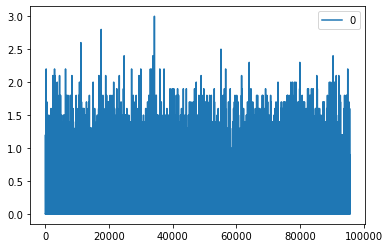

In [18]:
if train_agent:
    tf.compat.v1.disable_eager_execution()

    # initialize board
    board = ChessEnv(opponent=None)

    # create critic
    critic = ActorCriticAgent(network='cnn', lr=0.1)
    critic.update_model()
    # create actor
    actor = ActorCriticAgent(network='cnn_pg', lr=0.3, dense_layers=2, cnn_layers=2)

    # learn
    run_learning = ActorCritic(actor=actor, critic=critic, env=board)
    _pgn = run_learning.learn(iters=iters)

### Test Agents

In [19]:
def play_game(player, opponent, actor=False, display=False):
  # Create environment
  env = ChessEnv(opponent=opponent)

  # Play Game
  ## Starts with player
  is_white = 1
  total_game_time = 0

  turn = 1
  while not env._is_done():
    # set up base variables
    #root = node()
    #root.state = env.board
    state = env.board
    action = None
    current_player = player if is_white else env.opponent

    # observe action to take
    #print('Turn: {}'.format(turn))
    start = time.time()
    actor_move=False
    if is_white:
      action = player.observe(state, env=env)
      if actor:
        actor_move=True
    else:
      action = env.opponent.observe(state, env=env)
    end = time.time()
    duration = end - start
    total_game_time += duration
    # perform action
    if actor_move:
        episode_end, reward = env.step_numerical(action)
    else:
        env.step(action)
    if display:
      print('{} Moved: {}, time taken to move: {:.2f}s'.format(current_player.name, action, duration))
    

    if not is_white and display:
      env.render_image_jupyter()
    is_white ^= 1
    turn+=1

  return env, total_game_time

Created Agent Actor-Critic Based Agent
Created Agent Stockfish Agent as Black; Using Stockfish engine lvl: 1
============================== Starting Episode: 1 ==============================


/opt/conda/lib/python3.7/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Total Game Time: 3.684000253677368s

Final Board:


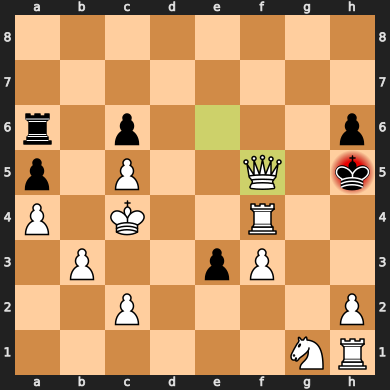


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 2 ==============================
Total Game Time: 9.938440084457397s

Final Board:


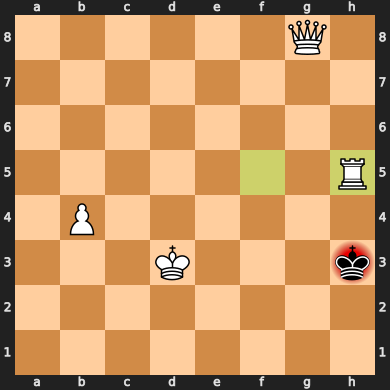


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 3 ==============================
Total Game Time: 8.204483985900879s

Final Board:


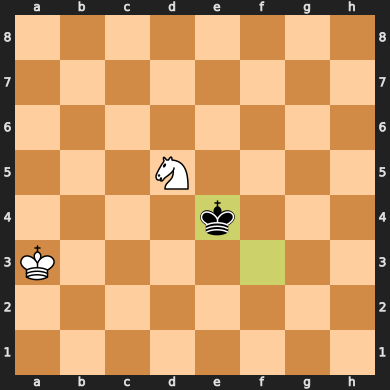


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 4 ==============================
Total Game Time: 5.850314378738403s

Final Board:


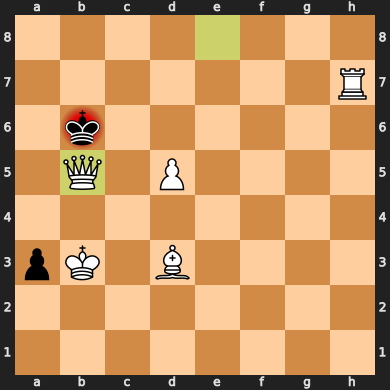


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 5 ==============================
Total Game Time: 6.980895757675171s

Final Board:


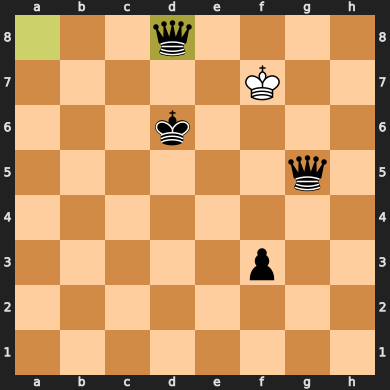


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 6 ==============================
Total Game Time: 7.207416296005249s

Final Board:


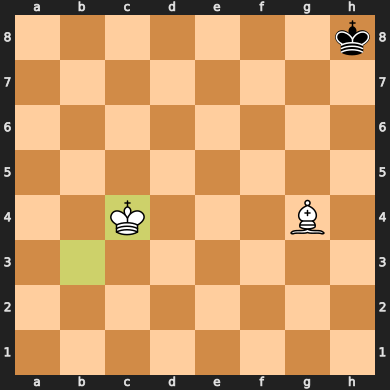


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 7 ==============================
Total Game Time: 11.434314727783203s

Final Board:


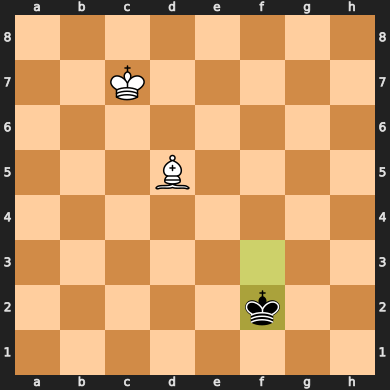


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 8 ==============================
Total Game Time: 7.439133405685425s

Final Board:


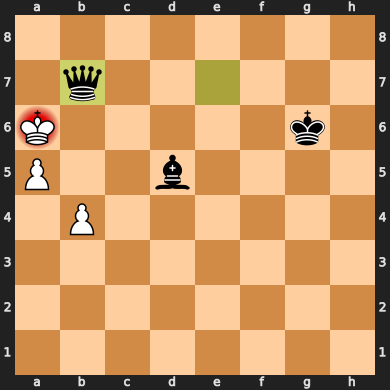


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 9 ==============================
Total Game Time: 10.341527938842773s

Final Board:


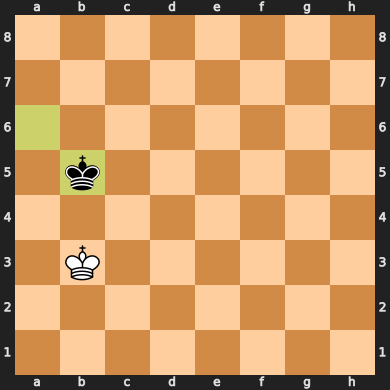


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 10 ==============================
Total Game Time: 6.906290292739868s

Final Board:


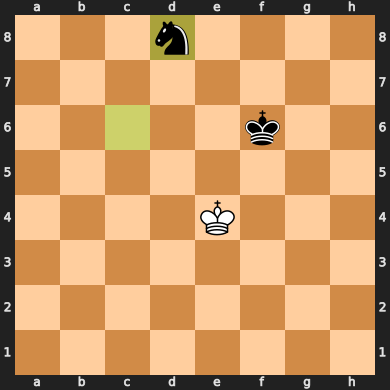


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 11 ==============================
Total Game Time: 4.415903329849243s

Final Board:


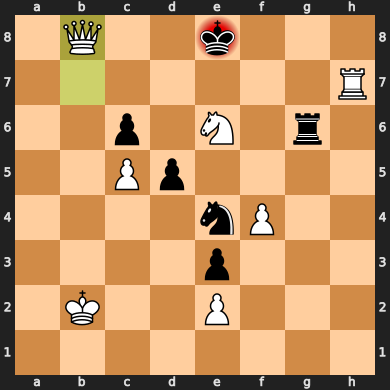


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 12 ==============================
Total Game Time: 5.484122037887573s

Final Board:


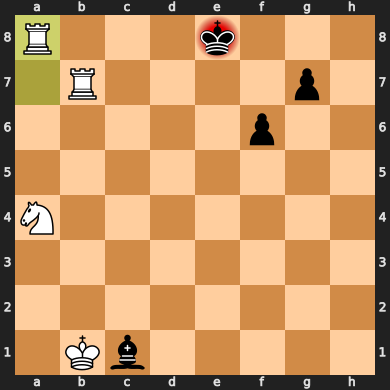


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 13 ==============================
Total Game Time: 1.0820567607879639s

Final Board:


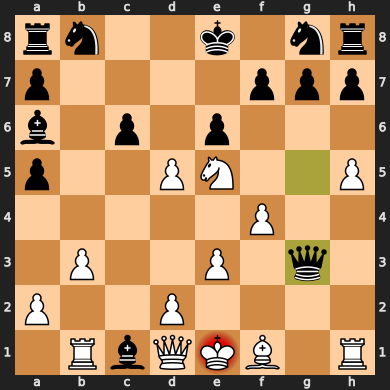


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 14 ==============================
Total Game Time: 10.50844693183899s

Final Board:


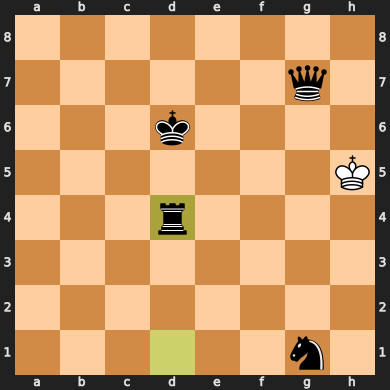


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 15 ==============================
Total Game Time: 9.278334856033325s

Final Board:


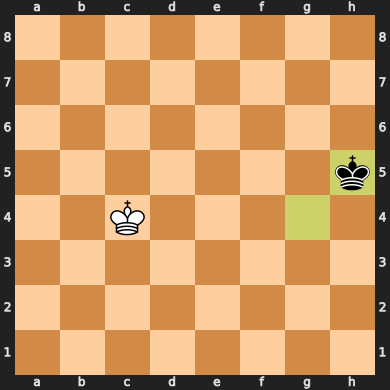


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 16 ==============================
Total Game Time: 12.561988830566406s

Final Board:


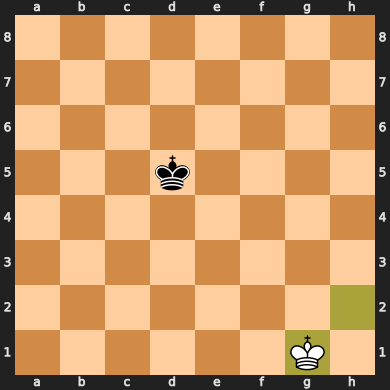


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 17 ==============================
Total Game Time: 2.918105363845825s

Final Board:


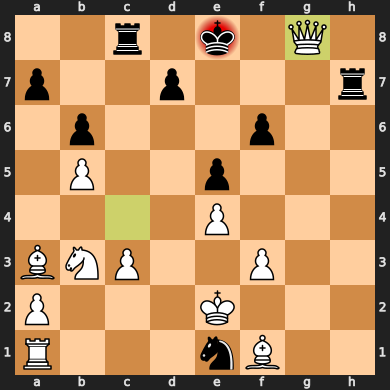


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 18 ==============================
Total Game Time: 11.67493724822998s

Final Board:


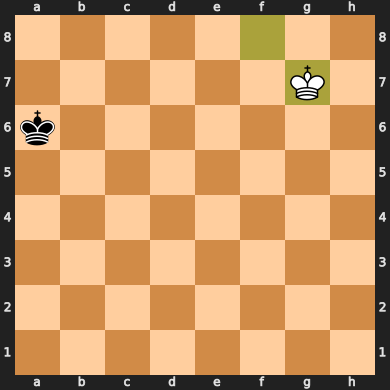


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 19 ==============================
Total Game Time: 8.487591743469238s

Final Board:


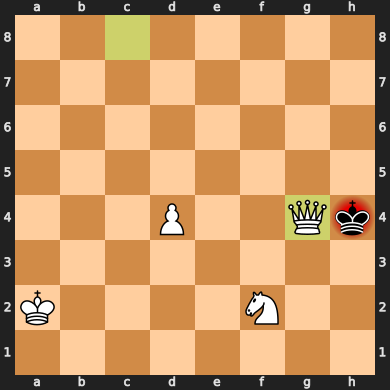


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 20 ==============================
Total Game Time: 7.12653374671936s

Final Board:


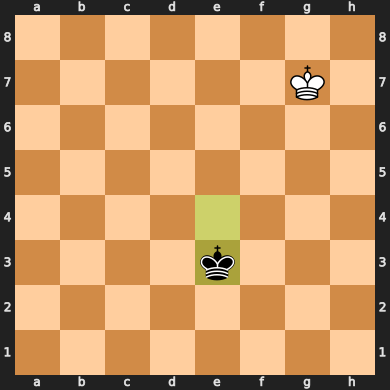


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 21 ==============================
Total Game Time: 10.545653581619263s

Final Board:


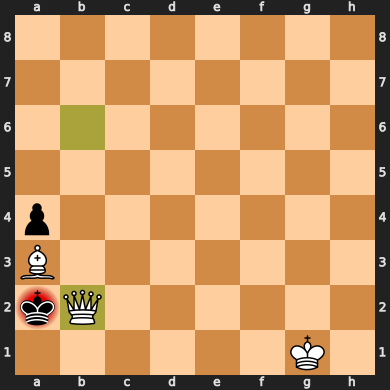


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 22 ==============================
Total Game Time: 5.3771071434021s

Final Board:


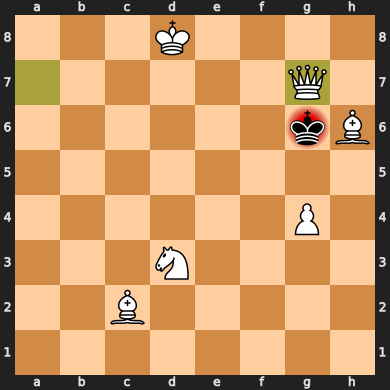


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 23 ==============================
Total Game Time: 4.093224287033081s

Final Board:


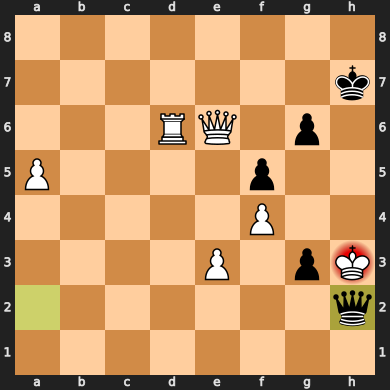


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 24 ==============================
Total Game Time: 10.896696329116821s

Final Board:


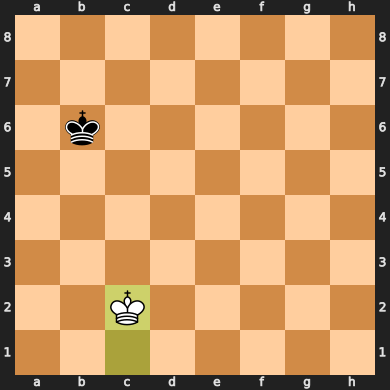


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 25 ==============================
Total Game Time: 4.977188348770142s

Final Board:


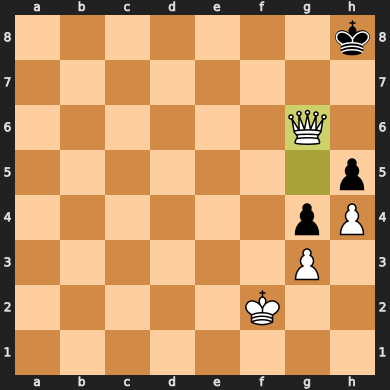


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 26 ==============================
Total Game Time: 11.433577537536621s

Final Board:


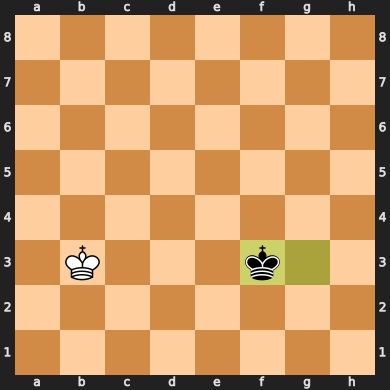


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 27 ==============================
Total Game Time: 2.262599468231201s

Final Board:


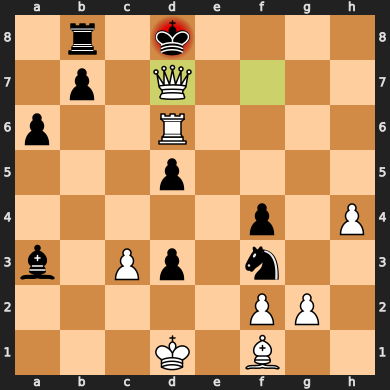


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 28 ==============================
Total Game Time: 3.445765495300293s

Final Board:


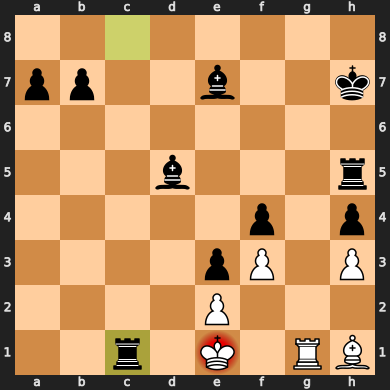


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 29 ==============================
Total Game Time: 1.6577317714691162s

Final Board:


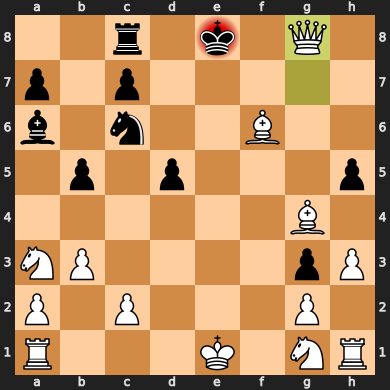


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 30 ==============================
Total Game Time: 2.781973361968994s

Final Board:


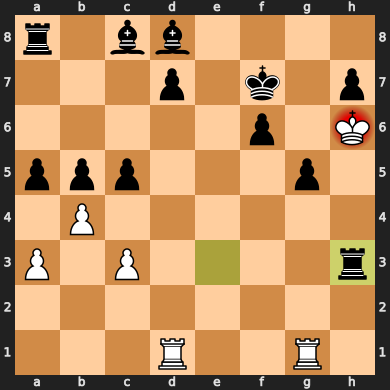


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 31 ==============================
Total Game Time: 7.662693977355957s

Final Board:


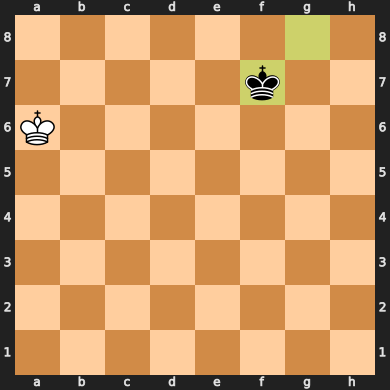


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 32 ==============================
Total Game Time: 7.002802610397339s

Final Board:


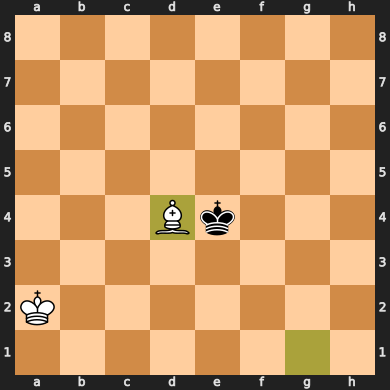


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 33 ==============================
Total Game Time: 4.736521005630493s

Final Board:


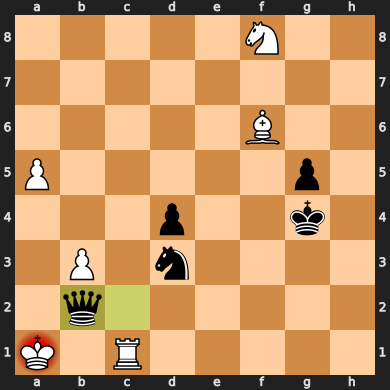


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 34 ==============================
Total Game Time: 7.217190980911255s

Final Board:


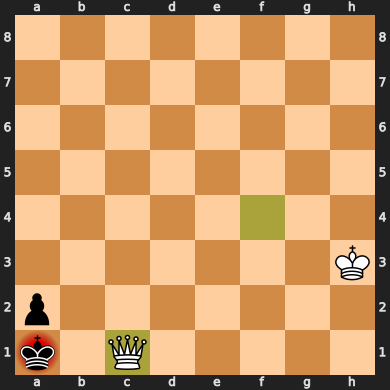


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 35 ==============================
Total Game Time: 8.41734766960144s

Final Board:


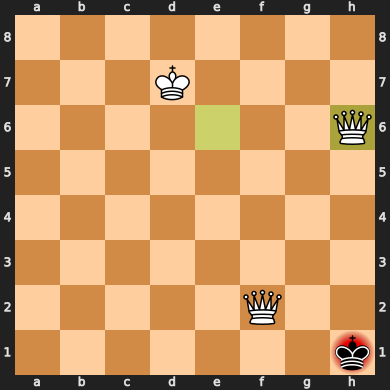


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 36 ==============================
Total Game Time: 7.455157041549683s

Final Board:


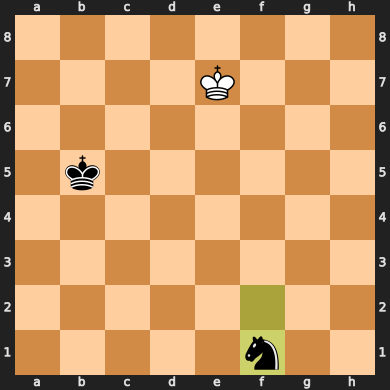


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 37 ==============================
Total Game Time: 16.76161789894104s

Final Board:


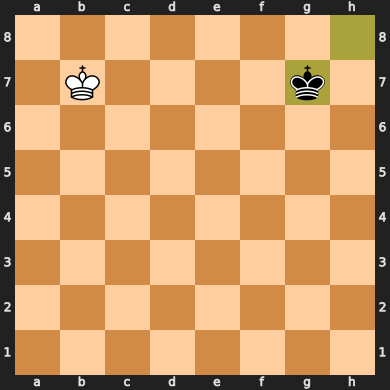


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 38 ==============================
Total Game Time: 11.345590353012085s

Final Board:


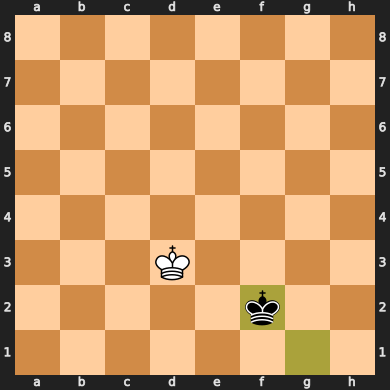


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 39 ==============================
Total Game Time: 7.663677215576172s

Final Board:


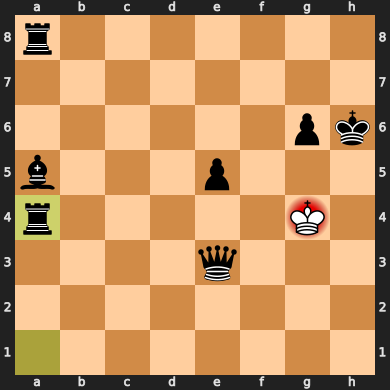


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 40 ==============================
Total Game Time: 8.109966039657593s

Final Board:


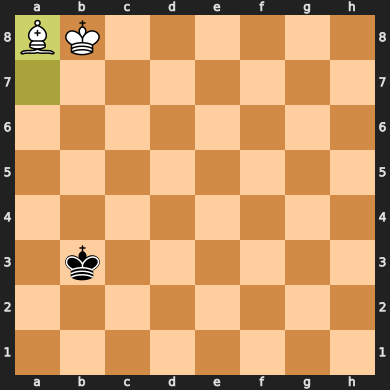


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 41 ==============================
Total Game Time: 0.6487836837768555s

Final Board:


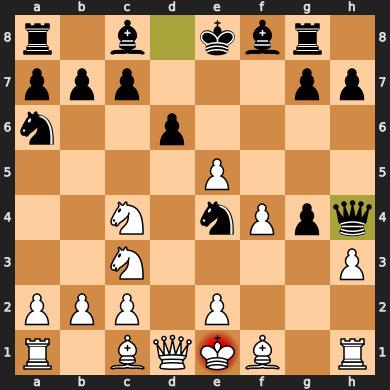


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 42 ==============================
Total Game Time: 11.659333944320679s

Final Board:


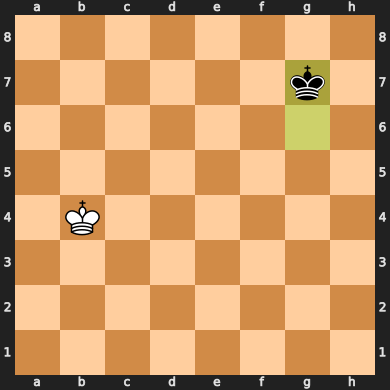


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 43 ==============================
Total Game Time: 12.676339626312256s

Final Board:


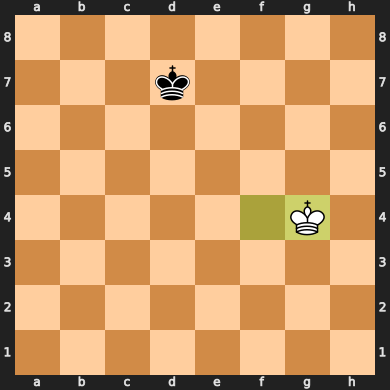


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 44 ==============================
Total Game Time: 8.069635391235352s

Final Board:


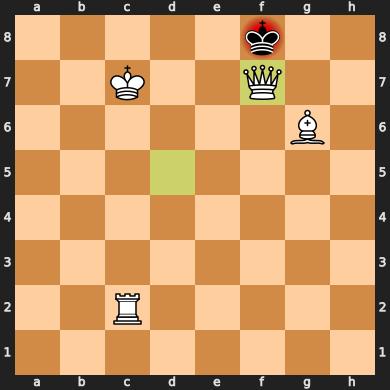


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 45 ==============================
Total Game Time: 10.224980115890503s

Final Board:


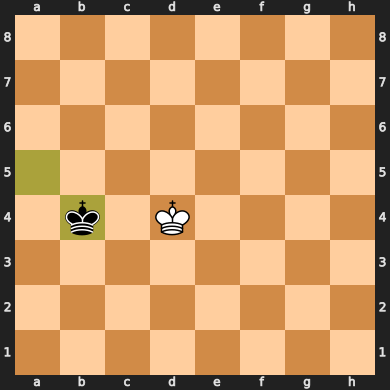


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 46 ==============================
Total Game Time: 4.407555103302002s

Final Board:


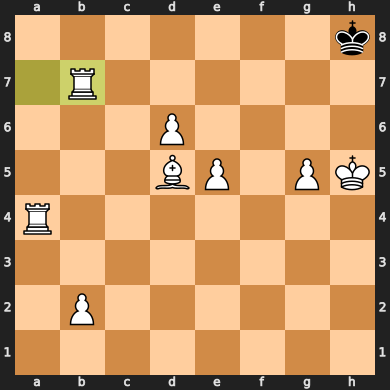


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 47 ==============================
Total Game Time: 5.718035697937012s

Final Board:


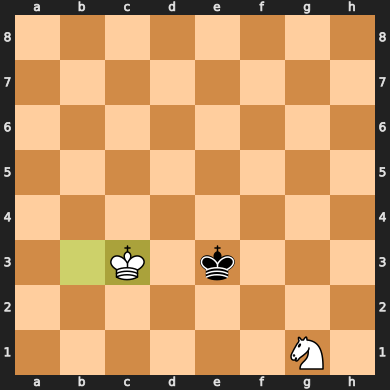


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 48 ==============================
Total Game Time: 8.64418077468872s

Final Board:


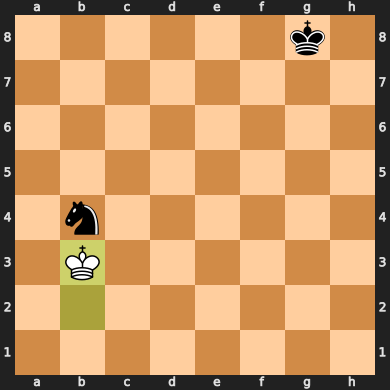


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 49 ==============================
Total Game Time: 8.189393758773804s

Final Board:


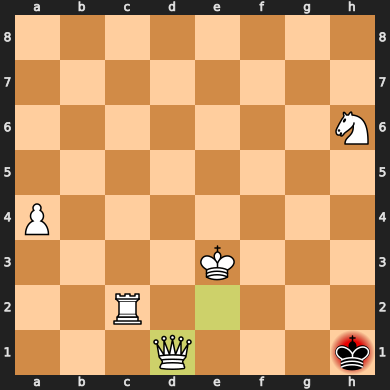


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 50 ==============================
Total Game Time: 2.84838604927063s

Final Board:


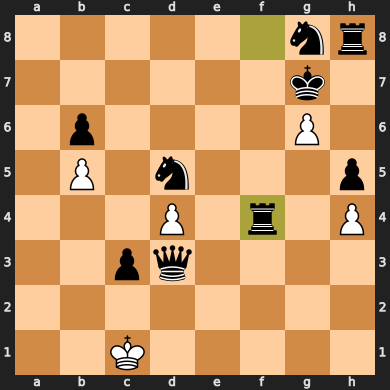


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 51 ==============================
Total Game Time: 5.017192363739014s

Final Board:


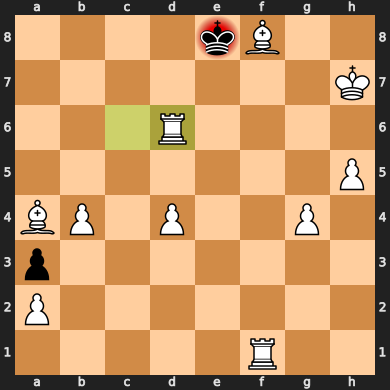


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 52 ==============================
Total Game Time: 12.358919382095337s

Final Board:


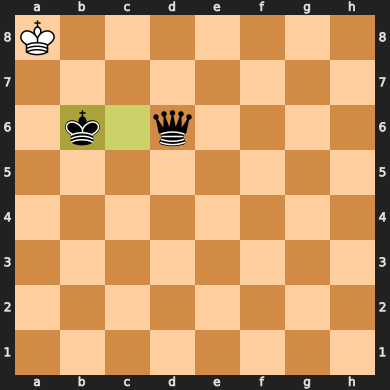


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 53 ==============================
Total Game Time: 15.21469759941101s

Final Board:


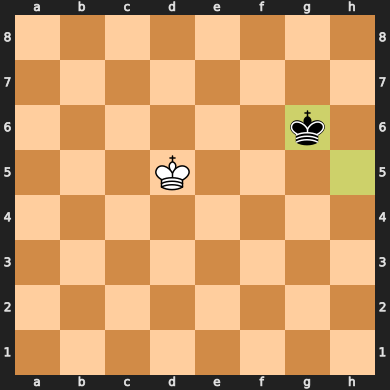


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 54 ==============================
Total Game Time: 1.8323121070861816s

Final Board:


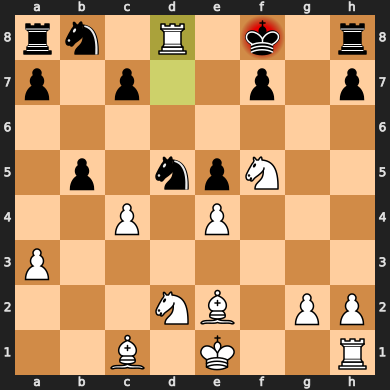


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 55 ==============================
Total Game Time: 14.237433910369873s

Final Board:


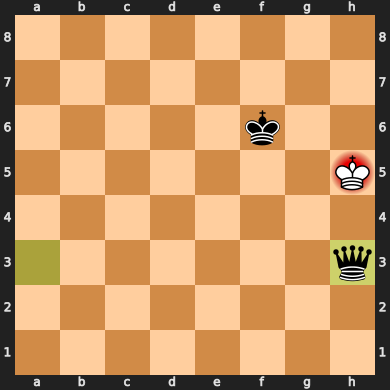


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 56 ==============================
Total Game Time: 7.33288049697876s

Final Board:


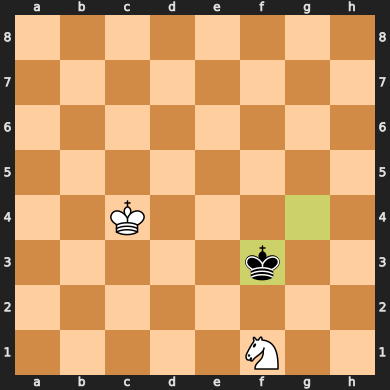


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 57 ==============================
Total Game Time: 10.65890884399414s

Final Board:


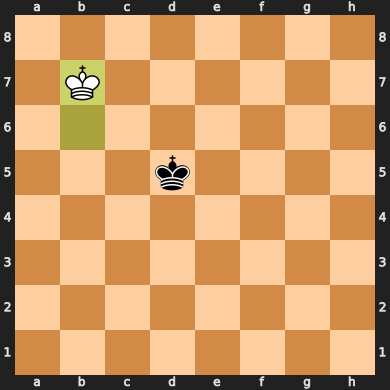


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 58 ==============================
Total Game Time: 1.207533597946167s

Final Board:


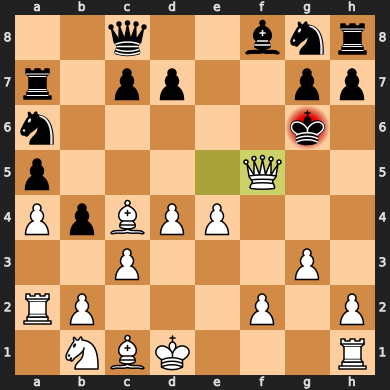


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 59 ==============================
Total Game Time: 7.760409355163574s

Final Board:


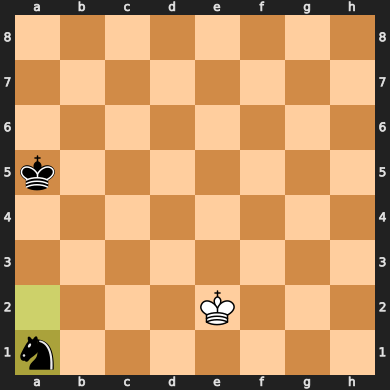


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 60 ==============================
Total Game Time: 9.738283395767212s

Final Board:


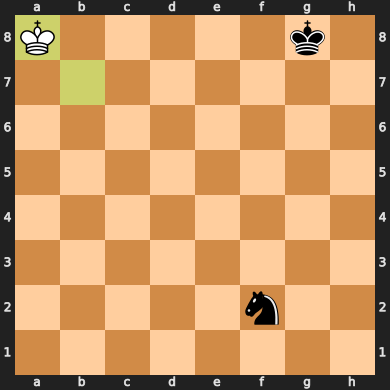


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 61 ==============================
Total Game Time: 3.6618175506591797s

Final Board:


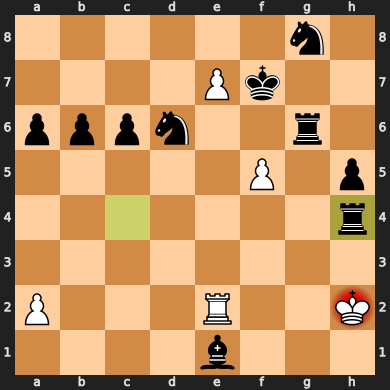


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 62 ==============================
Total Game Time: 10.06521987915039s

Final Board:


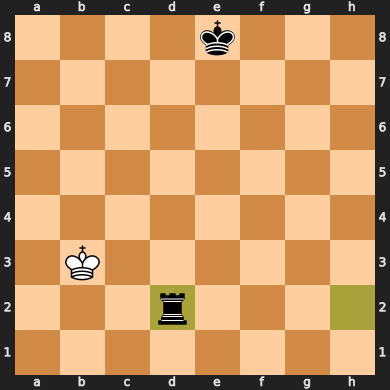


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 63 ==============================
Total Game Time: 10.483792066574097s

Final Board:


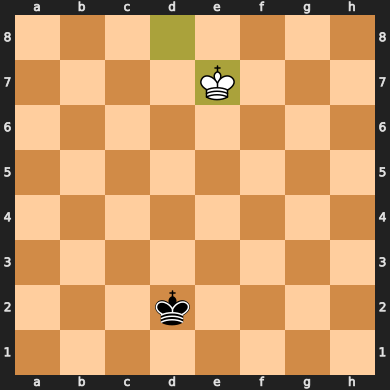


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 64 ==============================
Total Game Time: 1.0776870250701904s

Final Board:


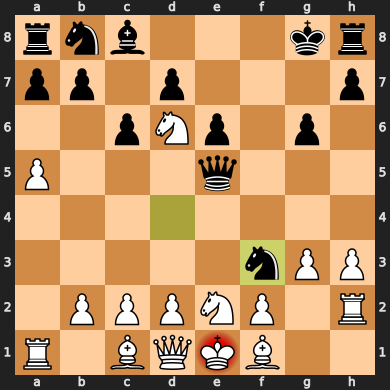


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 65 ==============================
Total Game Time: 3.02458119392395s

Final Board:


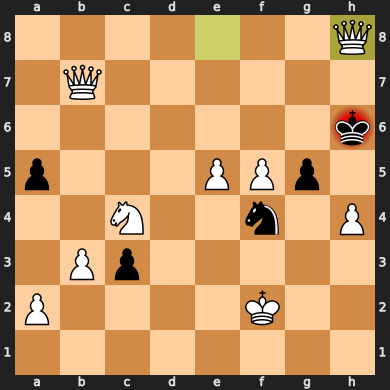


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 66 ==============================
Total Game Time: 10.083484888076782s

Final Board:


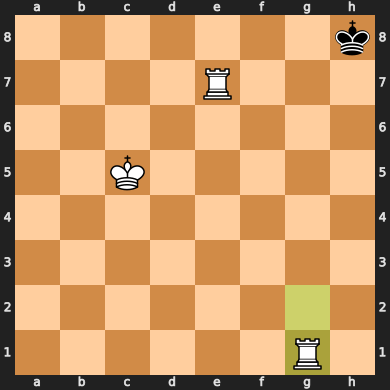


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 67 ==============================
Total Game Time: 2.039666175842285s

Final Board:


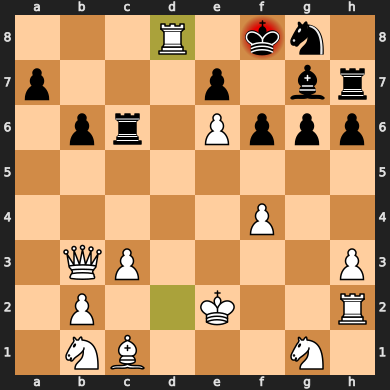


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 68 ==============================
Total Game Time: 4.623024225234985s

Final Board:


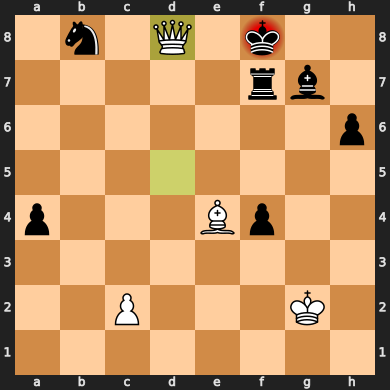


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 69 ==============================
Total Game Time: 8.618730068206787s

Final Board:


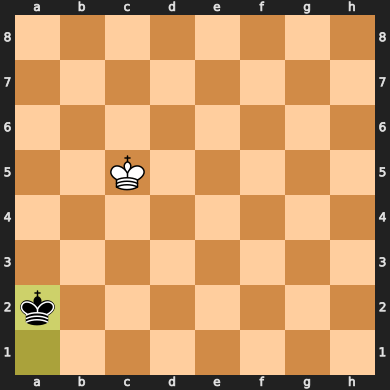


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 70 ==============================
Total Game Time: 6.247402191162109s

Final Board:


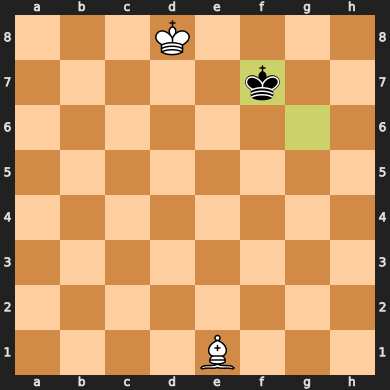


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 71 ==============================
Total Game Time: 4.9042582511901855s

Final Board:


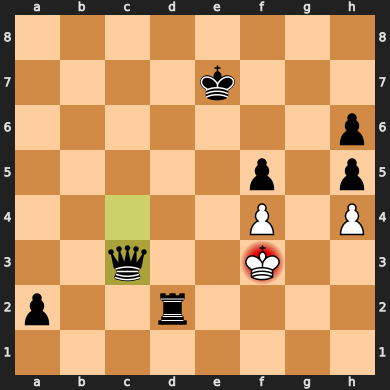


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 72 ==============================
Total Game Time: 10.032788515090942s

Final Board:


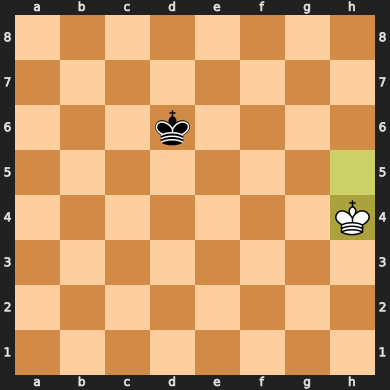


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 73 ==============================
Total Game Time: 10.33826756477356s

Final Board:


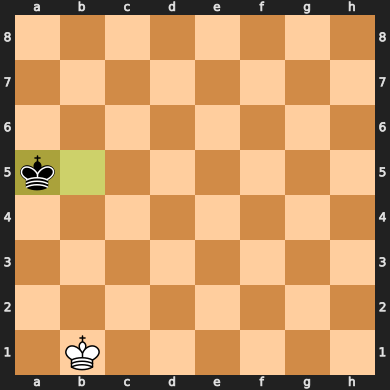


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 74 ==============================
Total Game Time: 9.28329086303711s

Final Board:


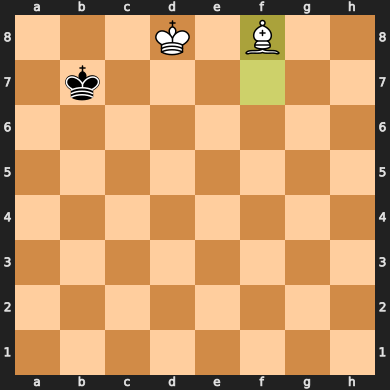


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 75 ==============================
Total Game Time: 11.628071546554565s

Final Board:


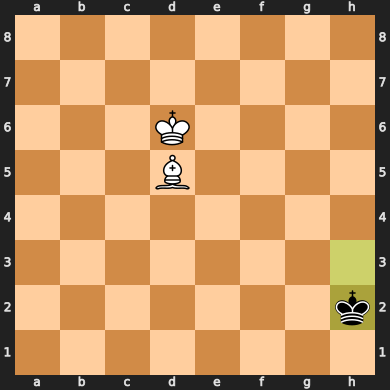


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 76 ==============================
Total Game Time: 8.9710373878479s

Final Board:


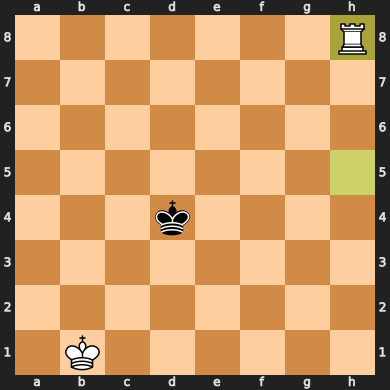


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 77 ==============================
Total Game Time: 5.053329944610596s

Final Board:


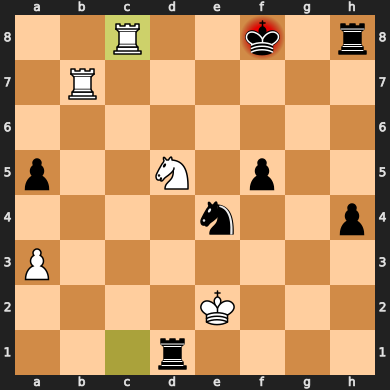


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 78 ==============================
Total Game Time: 6.422349452972412s

Final Board:


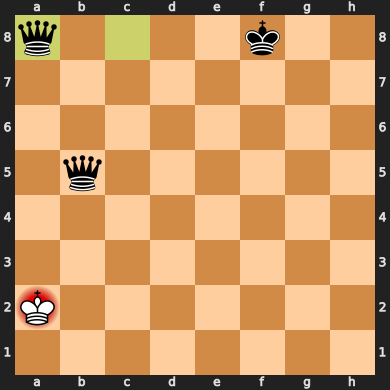


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 79 ==============================
Total Game Time: 7.2635321617126465s

Final Board:


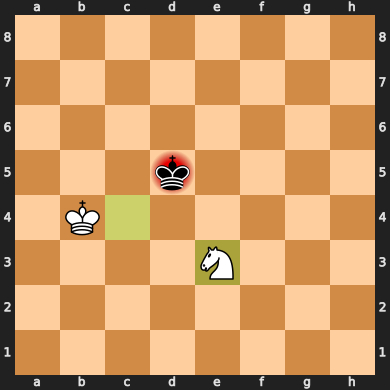


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 80 ==============================
Total Game Time: 6.36731219291687s

Final Board:


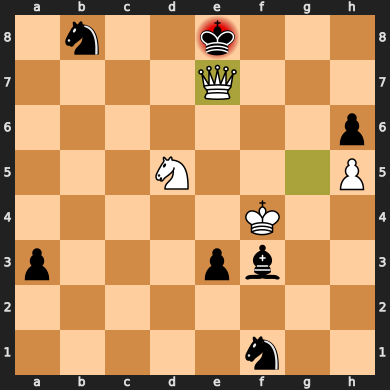


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 81 ==============================
Total Game Time: 10.818638324737549s

Final Board:


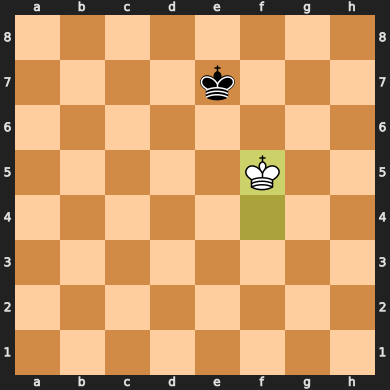


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 82 ==============================
Total Game Time: 4.572566032409668s

Final Board:


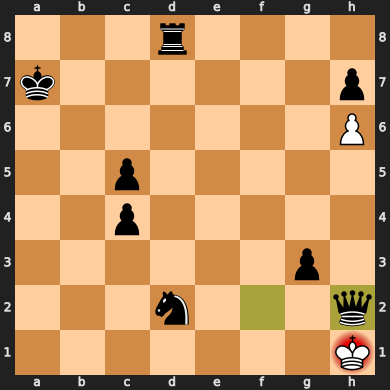


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 83 ==============================
Total Game Time: 1.2943165302276611s

Final Board:


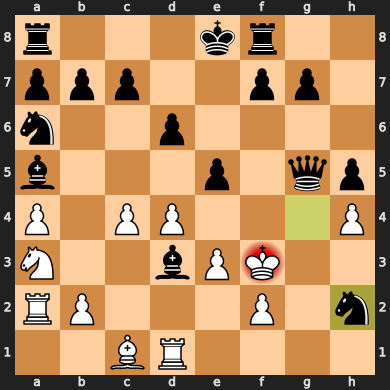


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 84 ==============================
Total Game Time: 6.069475889205933s

Final Board:


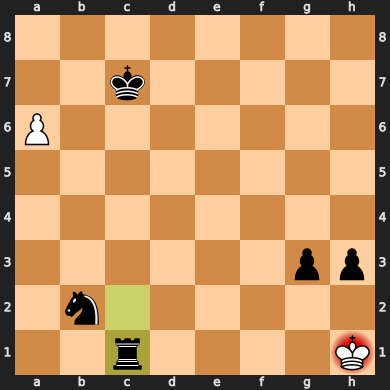


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 85 ==============================
Total Game Time: 8.85593867301941s

Final Board:


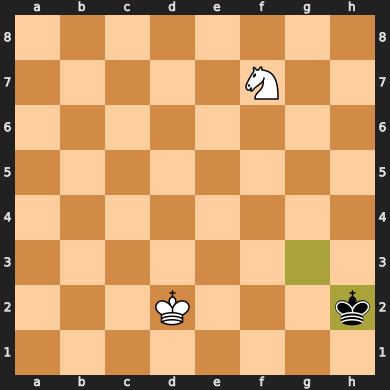


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 86 ==============================
Total Game Time: 4.192370176315308s

Final Board:


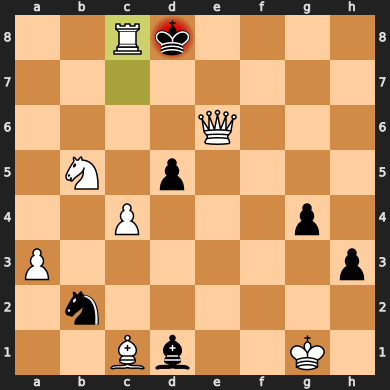


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 87 ==============================
Total Game Time: 3.356281280517578s

Final Board:


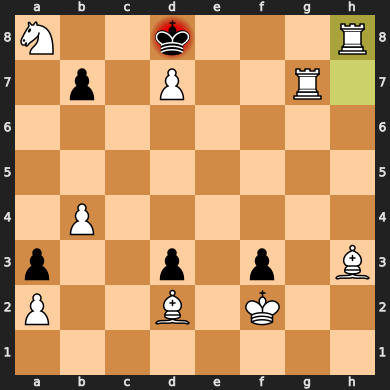


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 88 ==============================
Total Game Time: 8.625747680664062s

Final Board:


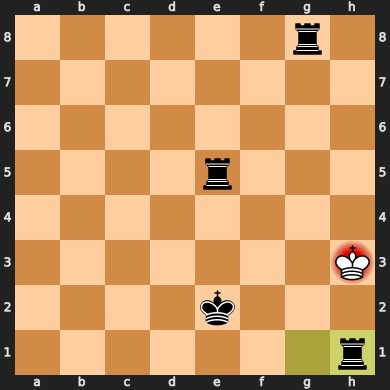


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 89 ==============================
Total Game Time: 3.842294216156006s

Final Board:


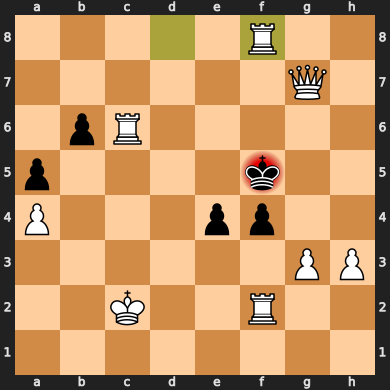


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 90 ==============================
Total Game Time: 10.233336687088013s

Final Board:


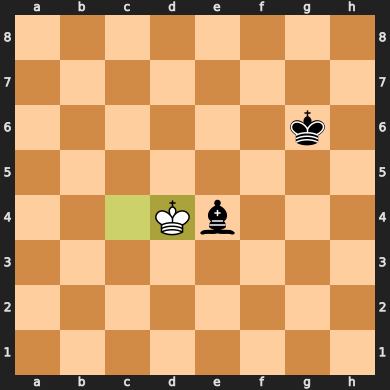


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 91 ==============================
Total Game Time: 9.686439752578735s

Final Board:


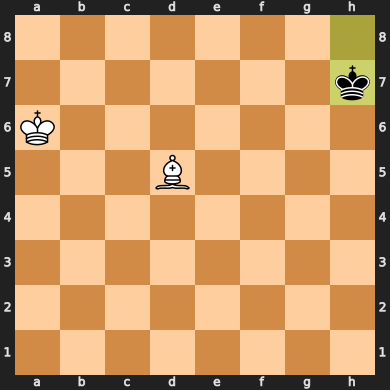


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 92 ==============================
Total Game Time: 3.844742774963379s

Final Board:


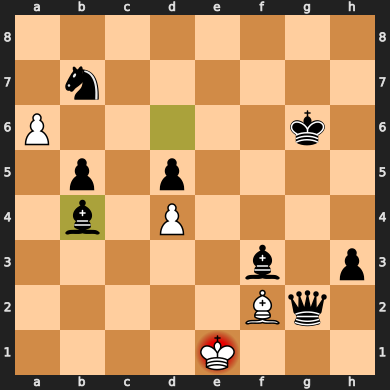


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 93 ==============================
Total Game Time: 6.034225225448608s

Final Board:


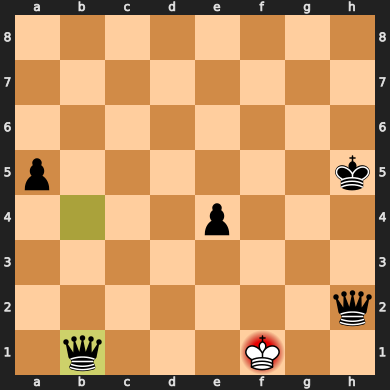


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 94 ==============================
Total Game Time: 10.429538488388062s

Final Board:


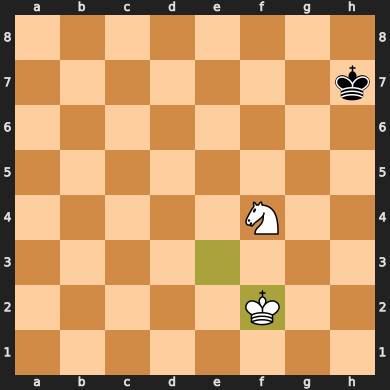


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 95 ==============================
Total Game Time: 7.846833944320679s

Final Board:


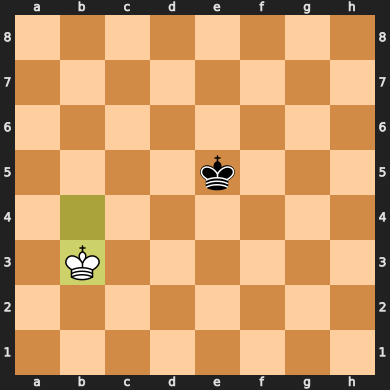


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 96 ==============================
Total Game Time: 5.535840034484863s

Final Board:


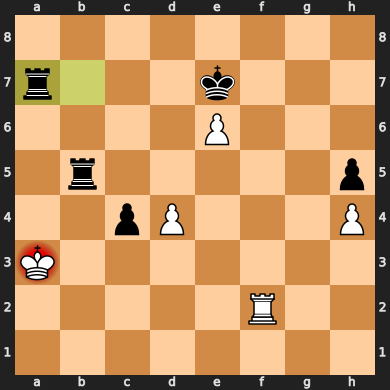


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 97 ==============================
Total Game Time: 13.125555276870728s

Final Board:


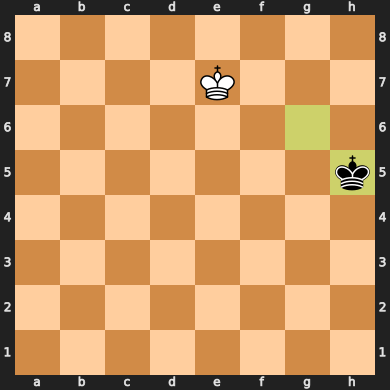


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 98 ==============================
Total Game Time: 4.4799370765686035s

Final Board:


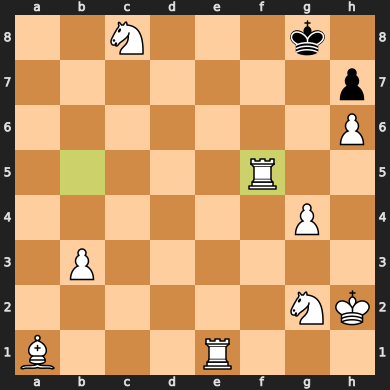


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 99 ==============================
Total Game Time: 8.639324426651001s

Final Board:


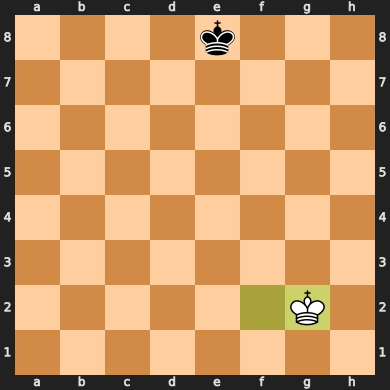


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 100 ==============================
Total Game Time: 4.9068427085876465s

Final Board:


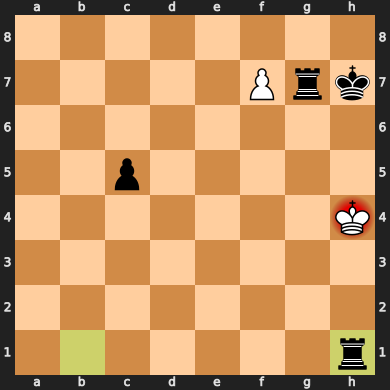


(Black) Stockfish Agent - Won the Game


============================== SUMMARY ==============================
Actor-Critic Based Agent -- Wins: 26
Stockfish Agent -- Wins: 21
Draws: 53


In [20]:
# Create opponent
#opponent = MCTSAgent(name='MCTS Based Agent', is_white=False, multithreading=False)
#player = MCTSAgent(name='Player', is_white=True, multithreading=False)
#actor=False
player = ActorCriticAgent(network='cnn_pg', lr=0.3, dense_layers=2, cnn_layers=2, name='Actor-Critic Based Agent')
player.load_model(name=save_path+'/actor_final.h5')
actor=True
opponent = StockfishAgent(name='Stockfish Agent', is_white=False)

games = 100
episode = 0

white_wins = 0
black_wins = 0
draws = 0

while episode < games:
  print('='*30 + ' Starting Episode: {} '.format(episode+1) + '='*30)
  env, total_game_time = play_game(player, opponent, actor=actor)

  print('Total Game Time: {}s'.format(total_game_time))
  print('')
  print('Final Board:')
  env.render_image_jupyter()
  print('')

  reward = env._reward()

  if reward == 1:
    print('(White) {} - Won the Game'.format(player.name))
    white_wins+=1
  elif reward == -1:
    print('(Black) {} - Won the Game'.format(env.opponent.name))
    black_wins+=1
  else:
    print('Game was a Draw between {} vs. {}'.format(player.name, env.opponent.name))
    draws+=1

  episode += 1

print('')
print('')
print('='*30 + ' SUMMARY '.format(episode+1) + '='*30)
print('{} -- Wins: {}'.format(player.name, white_wins))
print('{} -- Wins: {}'.format(opponent.name, black_wins))
print('Draws: {}'.format(draws))